# Content-Based Filtering - Système de Recommandation

Implémentation de 3 approches Content-Based pour la recommandation d'articles

In [1]:
import pandas as pd
import numpy as np
import pickle
import glob
from datetime import datetime, timedelta
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

## 1. Chargement des Données

In [2]:
# Métadonnées des articles
articles_df = pd.read_csv('data/articles_metadata.csv')
articles_df = articles_df.drop_duplicates(subset=['article_id'])
articles_df = articles_df[(articles_df['words_count'] >= 10) & (articles_df['words_count'] <= 2000)]
articles_df['created_at'] = pd.to_datetime(articles_df['created_at_ts'], unit='ms')

# Embeddings
with open('data/articles_embeddings.pickle', 'rb') as f:
    articles_embeddings = pickle.load(f)
embeddings_array = np.array(articles_embeddings)

# Données de clics
click_files = sorted(glob.glob('data/clicks/clicks_hour_*.csv'))[:150]
clicks_df = pd.concat([pd.read_csv(f) for f in click_files], ignore_index=True)

# Nettoyage
clicks_df = clicks_df.drop_duplicates()
clicks_df = clicks_df[clicks_df['session_size'] <= 200]
valid_articles = set(articles_df['article_id'].unique())
clicks_df = clicks_df[clicks_df['click_article_id'].isin(valid_articles)]

# Enrichissement temporel
clicks_df['click_timestamp_dt'] = pd.to_datetime(clicks_df['click_timestamp'], unit='ms')
clicks_df['session_start_dt'] = pd.to_datetime(clicks_df['session_start'], unit='ms')
clicks_df['time_to_click'] = (clicks_df['click_timestamp'] - clicks_df['session_start']) / 1000
clicks_df = clicks_df[(clicks_df['time_to_click'] >= 0) & (clicks_df['time_to_click'] <= 3600)]

## 2. Approche 1: Popularité Temporelle Avancée

In [3]:
class TemporalPopularityRecommender:
    def __init__(self, clicks_df, articles_df, temporal_decay=0.95, freshness_boost=0.3):
        self.clicks_df = clicks_df
        self.articles_df = articles_df
        self.temporal_decay = temporal_decay
        self.freshness_boost = freshness_boost
        self._calculate_scores()
    
    def _calculate_scores(self):
        max_date = self.clicks_df['click_timestamp_dt'].max()
        self.clicks_df['days_ago'] = (max_date - self.clicks_df['click_timestamp_dt']).dt.days
        self.clicks_df['temporal_weight'] = self.temporal_decay ** self.clicks_df['days_ago']
        
        self.article_scores = self.clicks_df.groupby('click_article_id').agg({
            'temporal_weight': 'sum',
            'time_to_click': 'mean',
            'session_id': 'nunique',
            'user_id': 'nunique'
        }).rename(columns={
            'temporal_weight': 'weighted_clicks',
            'time_to_click': 'avg_time_to_click',
            'session_id': 'unique_sessions',
            'user_id': 'unique_users'
        })
        
        max_time = self.article_scores['avg_time_to_click'].max()
        self.article_scores['engagement_score'] = 1 - (self.article_scores['avg_time_to_click'] / max_time)
        
        total_clicks = self.clicks_df['click_article_id'].value_counts()
        self.article_scores['diversity_score'] = (self.article_scores['unique_users'] / total_clicks).fillna(0)
        
        self.article_scores['final_score'] = (
            0.4 * self.article_scores['weighted_clicks'] / self.article_scores['weighted_clicks'].max() +
            0.3 * self.article_scores['engagement_score'] +
            0.2 * self.article_scores['diversity_score'] / self.article_scores['diversity_score'].max() +
            0.1 * self.article_scores['unique_sessions'] / self.article_scores['unique_sessions'].max()
        )
        
        self.article_scores = self.article_scores.merge(
            self.articles_df[['article_id', 'category_id', 'created_at']], 
            left_index=True, right_on='article_id', how='left'
        ).set_index('article_id')
        
        # Ajouter le boost de fraîcheur
        if 'created_at' in self.article_scores.columns:
            article_age_days = (max_date - pd.to_datetime(self.article_scores['created_at'])).dt.days
            freshness_factor = 1 / (1 + article_age_days / 7)  # Décroissance hebdomadaire
            self.article_scores['final_score'] *= (1 + self.freshness_boost * freshness_factor)
        
        self.article_scores = self.article_scores.sort_values('final_score', ascending=False)
    
    def recommend(self, n=10, exclude=None, max_per_category=3):
        if exclude is None:
            exclude = set()
        
        recommendations = []
        category_counts = defaultdict(int)
        
        for article_id in self.article_scores.index:
            if article_id in exclude:
                continue
            
            category = self.article_scores.loc[article_id, 'category_id']
            if category_counts[category] >= max_per_category:
                if self.article_scores.loc[article_id, 'final_score'] < self.article_scores['final_score'].quantile(0.9):
                    continue
            
            recommendations.append(article_id)
            category_counts[category] += 1
            
            if len(recommendations) >= n:
                break
        
        return recommendations

## 3. Approche 2: Similarité Multi-Facettes

In [4]:
class MultiFacetSimilarityRecommender:
    def __init__(self, embeddings, articles_df, clicks_df):
        self.embeddings = embeddings
        self.articles_df = articles_df
        self.clicks_df = clicks_df
        self._prepare_features()
    
    def _prepare_features(self):
        self.article_behavior = self.clicks_df.groupby('click_article_id').agg({
            'time_to_click': ['mean', 'std'],
            'session_id': 'nunique',
            'user_id': 'nunique'
        })
        self.article_behavior.columns = ['_'.join(col).strip() for col in self.article_behavior.columns]
        
        session_articles = self.clicks_df.groupby('session_id')['click_article_id'].apply(list)
        self.cooccurrence = defaultdict(lambda: defaultdict(int))
        for articles in session_articles:
            for i, a1 in enumerate(articles):
                for a2 in articles[i+1:min(i+6, len(articles))]:
                    if a1 != a2:
                        self.cooccurrence[a1][a2] += 1
                        self.cooccurrence[a2][a1] += 1
        
        self.category_profiles = self.clicks_df.merge(
            self.articles_df[['article_id', 'category_id']], 
            left_on='click_article_id', right_on='article_id'
        ).groupby(['user_id', 'category_id']).size().unstack(fill_value=0)
        self.category_profiles = self.category_profiles.div(self.category_profiles.sum(axis=1), axis=0)
        
        # Précalculer la popularité pour le filtrage
        self.article_popularity = self.clicks_df['click_article_id'].value_counts()
    
    def build_user_profile(self, user_id, time_window=30):
        user_clicks = self.clicks_df[self.clicks_df['user_id'] == user_id].copy()
        
        if len(user_clicks) == 0:
            return None
        
        if time_window:
            cutoff = user_clicks['click_timestamp_dt'].max() - pd.Timedelta(days=time_window)
            user_clicks = user_clicks[user_clicks['click_timestamp_dt'] >= cutoff]
        
        user_articles = user_clicks['click_article_id'].value_counts()
        max_date = user_clicks['click_timestamp_dt'].max()
        user_clicks['time_weight'] = 1 / (1 + (max_date - user_clicks['click_timestamp_dt']).dt.days)
        
        weighted_embeddings = []
        weights = []
        
        for article_id in user_articles.index:
            if article_id < len(self.embeddings):
                weight = user_clicks[user_clicks['click_article_id'] == article_id]['time_weight'].sum()
                weighted_embeddings.append(self.embeddings[article_id])
                weights.append(weight)
        
        if not weighted_embeddings:
            return None
        
        weights = np.array(weights) / np.sum(weights)
        embedding_profile = np.average(weighted_embeddings, axis=0, weights=weights)
        
        category_profile = self.category_profiles.loc[user_id].values if user_id in self.category_profiles.index else np.zeros(self.category_profiles.shape[1])
        
        # Ajouter le profil comportemental
        behavior_stats = {
            'avg_time_to_click': user_clicks['time_to_click'].mean(),
            'std_time_to_click': user_clicks['time_to_click'].std()
        }
        
        return {
            'embedding': embedding_profile,
            'categories': category_profile,
            'behavior': behavior_stats,
            'clicked': set(user_articles.index),
            'recent': set(user_clicks.tail(10)['click_article_id'].values)
        }
    
    def score_article(self, user_profile, article_id):
        if article_id >= len(self.embeddings):
            return 0
        
        # 1. Similarité d'embedding
        article_embedding = self.embeddings[article_id]
        embedding_sim = np.dot(user_profile['embedding'], article_embedding) / (
            np.linalg.norm(user_profile['embedding']) * np.linalg.norm(article_embedding) + 1e-10
        )
        
        # 2. Similarité de catégorie
        category_sim = 0
        if article_id in self.articles_df['article_id'].values:
            article_cat = self.articles_df[self.articles_df['article_id'] == article_id]['category_id'].iloc[0]
            if len(user_profile['categories']) > 0 and article_cat in self.category_profiles.columns:
                cat_idx = list(self.category_profiles.columns).index(article_cat)
                category_sim = user_profile['categories'][cat_idx]
        
        # 3. Similarité comportementale (CORRIGÉ)
        behavior_sim = 0
        if article_id in self.article_behavior.index:
            article_time = self.article_behavior.loc[article_id, 'time_to_click_mean']
            user_time = user_profile['behavior']['avg_time_to_click']
            time_diff = abs(article_time - user_time) / (max(article_time, user_time) + 1e-10)
            behavior_sim = max(0, 1 - time_diff)
        
        # 4. Bonus de co-occurrence
        cooccurrence_bonus = 0
        if article_id in self.cooccurrence:
            for recent in user_profile['recent']:
                if recent in self.cooccurrence[article_id]:
                    cooccurrence_bonus += self.cooccurrence[article_id][recent]
        
        if cooccurrence_bonus > 0:
            max_cooc = max(max(v.values()) for v in self.cooccurrence.values() if v)
            cooccurrence_bonus = min(cooccurrence_bonus / max_cooc, 0.1)  # Réduit de 0.2 à 0.1
        
        # FORMULE CORRIGÉE
        return (0.5 * embedding_sim + 
                0.2 * category_sim + 
                0.2 * behavior_sim +  # Au lieu de répéter embedding_sim
                0.1 * cooccurrence_bonus)
    
    def recommend(self, user_id, n=10, exploration_rate=0.1):  # Réduit de 0.2 à 0.1
        user_profile = self.build_user_profile(user_id)
        
        if not user_profile:
            return []
        
        all_articles = set(self.articles_df['article_id'].values)
        candidates = list(all_articles - user_profile['clicked'])
        
        # Filtrer pour garder seulement les articles avec un minimum de popularité
        if hasattr(self, 'article_popularity'):
            min_clicks = 2  # Au moins 2 clics
            candidates = [a for a in candidates if self.article_popularity.get(a, 0) >= min_clicks]
        
        # Limiter le nombre de candidats mais augmenter la qualité
        if len(candidates) > 500:  # Réduit de 1000 à 500
            # Prendre les 500 articles les plus populaires parmi les candidats
            candidates = sorted(candidates, 
                              key=lambda x: self.article_popularity.get(x, 0), 
                              reverse=True)[:500]
        
        scored = [(art, self.score_article(user_profile, art)) for art in candidates]
        scored.sort(key=lambda x: x[1], reverse=True)
        
        # Réduire l'exploration
        n_exploit = int(n * (1 - exploration_rate))
        recommendations = [art for art, _ in scored[:n_exploit]]
        
        # Exploration depuis le top 50-150 (pas complètement aléatoire)
        if len(scored) > n_exploit:
            explore_pool = scored[50:min(150, len(scored))]  # Meilleure qualité d'exploration
            n_explore = min(n - len(recommendations), len(explore_pool))
            if n_explore > 0:
                explore_indices = np.random.choice(len(explore_pool), n_explore, replace=False)
                explore_items = [explore_pool[i][0] for i in explore_indices]
                recommendations.extend(explore_items)
        
        return recommendations[:n]

## 4. Approche 3: Système Hybride

In [5]:
class HybridRecommender:
    def __init__(self, embeddings, articles_df, clicks_df, popularity_weight=0.3):
        self.embeddings = embeddings
        self.articles_df = articles_df
        self.clicks_df = clicks_df
        self.popularity_weight = popularity_weight
        self.article_popularity = clicks_df['click_article_id'].value_counts()
        self.max_popularity = self.article_popularity.max()
    
    def get_user_profile(self, user_id):
        user_clicks = self.clicks_df[self.clicks_df['user_id'] == user_id]
        if len(user_clicks) == 0:
            return None
        
        user_articles = user_clicks['click_article_id'].value_counts()
        profile_embeddings = []
        weights = []
        
        for article_id, count in user_articles.items():
            if article_id < len(self.embeddings):
                profile_embeddings.append(self.embeddings[article_id])
                weights.append(count)
        
        if not profile_embeddings:
            return None
        
        weights = np.array(weights) / np.sum(weights)
        return np.average(profile_embeddings, axis=0, weights=weights)
    
    def score_articles(self, articles, user_profile):
        scores = []
        
        for article_id in articles:
            if article_id < len(self.embeddings):
                article_embedding = self.embeddings[article_id]
                similarity = np.dot(user_profile, article_embedding) / (
                    np.linalg.norm(user_profile) * np.linalg.norm(article_embedding) + 1e-10
                )
                
                popularity = self.article_popularity.get(article_id, 0) / self.max_popularity
                
                hybrid_score = (
                    (1 - self.popularity_weight) * similarity + 
                    self.popularity_weight * popularity
                )
                
                scores.append((article_id, hybrid_score))
        
        return sorted(scores, key=lambda x: x[1], reverse=True)
    
    def recommend(self, user_id, n=10):
        user_profile = self.get_user_profile(user_id)
        
        if user_profile is None:
            return list(self.article_popularity.head(n).index)
        
        seen_articles = set(self.clicks_df[self.clicks_df['user_id'] == user_id]['click_article_id'].unique())
        
        top_popular = []
        for article_id in self.article_popularity.index:
            if article_id not in seen_articles:
                top_popular.append(article_id)
            if len(top_popular) >= min(50, len(self.article_popularity)):
                break
        
        scored = self.score_articles(top_popular, user_profile)
        return [article_id for article_id, _ in scored[:n]]

## 5. Évaluation

In [6]:
def user_based_split(clicks_df, test_ratio=0.2, min_clicks=10):
    train_data, test_data = [], []
    user_counts = clicks_df['user_id'].value_counts()
    active_users = user_counts[user_counts >= min_clicks].index[:1000]
    
    for user_id in active_users:
        user_clicks = clicks_df[clicks_df['user_id'] == user_id].sort_values('click_timestamp')
        split_point = int(len(user_clicks) * (1 - test_ratio))
        train_data.append(user_clicks.iloc[:split_point])
        test_data.append(user_clicks.iloc[split_point:])
    
    return pd.concat(train_data, ignore_index=True), pd.concat(test_data, ignore_index=True)

def evaluate_recommendations(recommendations, actual, k_values=[5, 10, 20]):
    results = {}
    for k in k_values:
        top_k = recommendations[:k]
        hits = len(set(top_k) & set(actual))
        results[f'hit@{k}'] = 1 if hits > 0 else 0
        results[f'precision@{k}'] = hits / len(top_k) if top_k else 0
        results[f'recall@{k}'] = hits / len(actual) if actual else 0
    return results

In [7]:
def user_based_split(clicks_df, test_ratio=0.2, min_clicks=10):
    train_data, test_data = [], []
    user_counts = clicks_df['user_id'].value_counts()
    active_users = user_counts[user_counts >= min_clicks].index[:1000]
    
    for user_id in active_users:
        user_clicks = clicks_df[clicks_df['user_id'] == user_id].sort_values('click_timestamp')
        split_point = int(len(user_clicks) * (1 - test_ratio))
        train_data.append(user_clicks.iloc[:split_point])
        test_data.append(user_clicks.iloc[split_point:])
    
    return pd.concat(train_data, ignore_index=True), pd.concat(test_data, ignore_index=True)

def evaluate_recommendations(recommendations, actual, k_values=[5, 10, 20]):
    results = {}
    for k in k_values:
        top_k = recommendations[:k]
        hits = len(set(top_k) & set(actual))
        results[f'hit@{k}'] = 1 if hits > 0 else 0
        results[f'precision@{k}'] = hits / len(top_k) if len(top_k) > 0 else 0
        results[f'recall@{k}'] = hits / len(actual) if len(actual) > 0 else 0
    return results

In [8]:
# Split des données
train_df, test_df = user_based_split(clicks_df)

# Initialisation des modèles
pop_recommender = TemporalPopularityRecommender(train_df, articles_df)
sim_recommender = MultiFacetSimilarityRecommender(embeddings_array, articles_df, train_df)
hyb_recommender = HybridRecommender(embeddings_array, articles_df, train_df)

# Évaluation
test_users = test_df['user_id'].unique()[:100]
results = {'popularity': [], 'similarity': [], 'hybrid': []}

for user_id in test_users:
    seen = set(train_df[train_df['user_id'] == user_id]['click_article_id'].unique())
    actual = test_df[test_df['user_id'] == user_id]['click_article_id'].unique()

    if len(actual) > 0:
        # Popularité
        pop_recs = pop_recommender.recommend(n=20, exclude=seen)
        results['popularity'].append(evaluate_recommendations(pop_recs, actual))

        # Similarité
        sim_recs = sim_recommender.recommend(user_id, n=20)
        results['similarity'].append(evaluate_recommendations(sim_recs, actual))

        # Hybride
        hyb_recs = hyb_recommender.recommend(user_id, n=20)
        results['hybrid'].append(evaluate_recommendations(hyb_recs, actual))

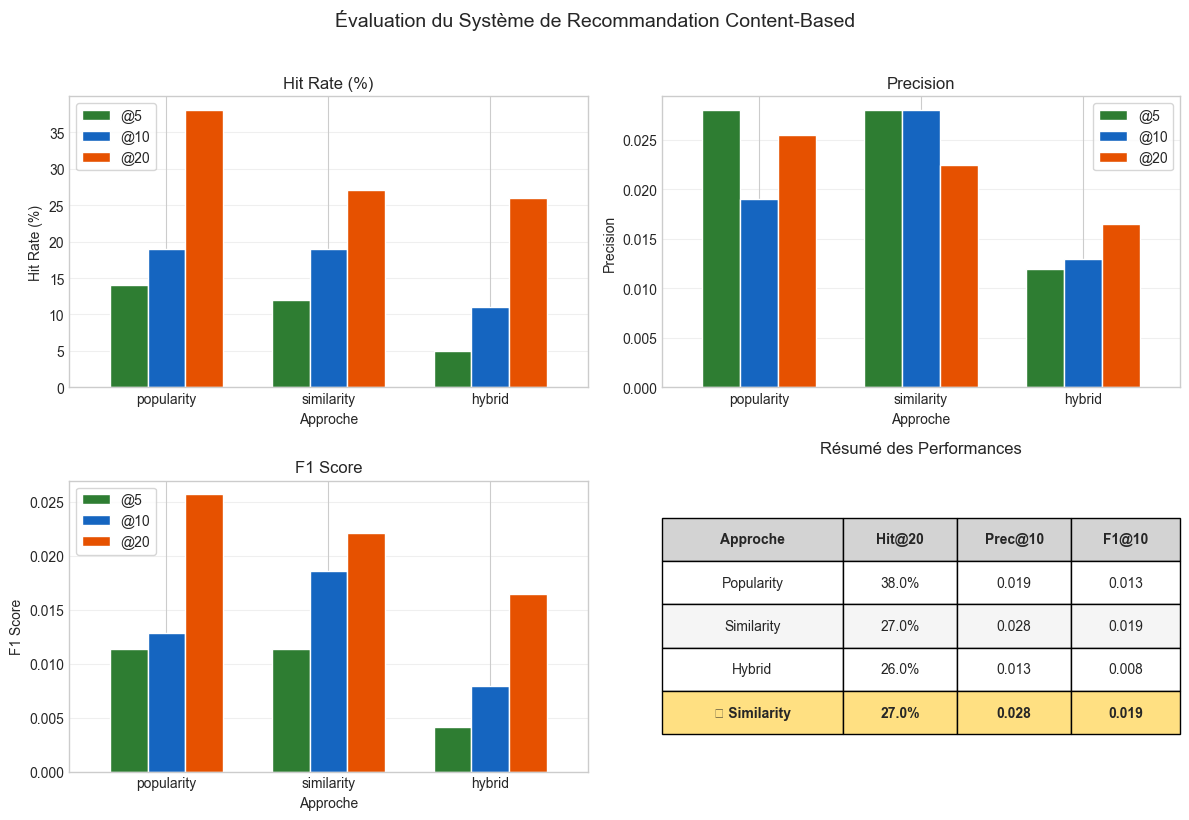

In [10]:
# Calcul des métriques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

summary = pd.DataFrame()

for approach, approach_results in results.items():
    if approach_results:
        metrics = {}
        for metric in approach_results[0].keys():
            metrics[metric] = np.mean([r[metric] for r in approach_results])
        summary[approach] = metrics

summary = summary.T

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#2E7D32', '#1565C0', '#E65100']

# Création de la figure avec 4 graphiques au lieu de 6
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Évaluation du Système de Recommandation Content-Based', fontsize=14, y=1.02)

# 1. Hit Rate comparison
ax1 = plt.subplot(2, 2, 1)
hit_data = summary[['hit@5', 'hit@10', 'hit@20']] * 100
hit_data.plot(kind='bar', ax=ax1, color=colors, width=0.7)
ax1.set_title('Hit Rate (%)', fontsize=12)
ax1.set_xlabel('Approche')
ax1.set_ylabel('Hit Rate (%)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(['@5', '@10', '@20'], frameon=True, loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# 2. Precision comparison
ax2 = plt.subplot(2, 2, 2)
precision_data = summary[['precision@5', 'precision@10', 'precision@20']]
precision_data.plot(kind='bar', ax=ax2, color=colors, width=0.7)
ax2.set_title('Precision', fontsize=12)
ax2.set_xlabel('Approche')
ax2.set_ylabel('Precision')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend(['@5', '@10', '@20'], frameon=True, loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# 3. F1 Scores
ax3 = plt.subplot(2, 2, 3)
f1_scores = pd.DataFrame()
for k in [5, 10, 20]:
    precision = summary[f'precision@{k}']
    recall = summary[f'recall@{k}']
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    f1_scores[f'@{k}'] = f1

f1_scores.plot(kind='bar', ax=ax3, color=colors, width=0.7)
ax3.set_title('F1 Score', fontsize=12)
ax3.set_xlabel('Approche')
ax3.set_ylabel('F1 Score')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.legend(frameon=True, loc='upper left')
ax3.grid(axis='y', alpha=0.3)

# 4. Tableau récapitulatif
ax4 = plt.subplot(2, 2, 4)
ax4.axis('tight')
ax4.axis('off')

# Préparer les données du tableau
table_data = []
for approach in summary.index:
    row = [
        approach.capitalize(),
        f"{summary.loc[approach, 'hit@20']:.1%}",
        f"{summary.loc[approach, 'precision@10']:.3f}",
        f"{f1_scores.loc[approach, '@10']:.3f}"
    ]
    table_data.append(row)

# Ajouter la ligne du meilleur modèle
best_f1 = f1_scores['@10'].idxmax()
winner_row = [
    f"🏆 {best_f1.capitalize()}",
    f"{summary.loc[best_f1, 'hit@20']:.1%}",
    f"{summary.loc[best_f1, 'precision@10']:.3f}",
    f"{f1_scores.loc[best_f1, '@10']:.3f}"
]
table_data.append(winner_row)

# Créer le tableau
table = ax4.table(cellText=table_data,
                colLabels=['Approche', 'Hit@20', 'Prec@10', 'F1@10'],
                cellLoc='center',
                loc='center',
                colWidths=[0.35, 0.22, 0.22, 0.21])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style du tableau
for i in range(len(table_data) + 1):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#D3D3D3')
            cell.set_text_props(weight='bold')
        elif i == len(table_data):  # Ligne gagnante
            cell.set_facecolor('#FFE082')
            cell.set_text_props(weight='bold')
        else:
            cell.set_facecolor('#F5F5F5' if i % 2 == 0 else 'white')

ax4.set_title('Résumé des Performances', fontsize=12, pad=20)

plt.tight_layout()
plt.show()